In [1]:
# Supress Warnings
import warnings
warnings.filterwarnings('ignore')

# Visualization
import ipyleaflet
import matplotlib.pyplot as plt
from IPython.display import Image
import seaborn as sns

# Data Science
import numpy as np
import pandas as pd
import dask
from dask.distributed import Client as daskClient

# Feature Engineering
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import QuantileTransformer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.impute import KNNImputer

# Machine Learning
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import CategoricalNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, accuracy_score,classification_report,confusion_matrix

# Planetary Computer Tools
import pystac
import pystac_client
import odc
from pystac_client import Client
from pystac.extensions.eo import EOExtension as eo
from odc.stac import stac_load
import planetary_computer as pc
pc.settings.set_subscription_key('df2f4d7a411942f8a5b81d60cb9b95ca')

# Others
import requests
import rich.table
import math
import random
from itertools import cycle
from tqdm import tqdm
from time import sleep
tqdm.pandas()

In [2]:
# Getting data from CSV file
crop_presence_data = pd.read_csv("Crop_Location_Data.csv")
crop_presence_data.head()

,Latitude and Longitude,Class of Land
0,"(10.323727047081501, 105.2516346045924)",Rice
1,"(10.322364360592521, 105.27843410554115)",Rice
2,"(10.321455902933202, 105.25254306225168)",Rice
3,"(10.324181275911162, 105.25118037576274)",Rice
4,"(10.324635504740822, 105.27389181724476)",Rice


# Sentinel 1

In [97]:
def get_sentinel_data(latlong,time_slice):
    '''
    Returns VV and VH values for a given latitude and longitude 
    Attributes:
    latlong - A tuple with 2 elements - latitude and longitude
    time_slice - Timeframe for which the VV and VH values have to be extracted
    '''

    latlong=latlong.replace('(','').replace(')','').replace(' ','').split(',')
    
    lat_long = list(map(float,latlong))
    time_of_interest = time_slice
    
    box_size_deg = 0.0004 # Surrounding box in degrees, yields approximately 5x5 pixel region

    min_lon = lat_long[1]-box_size_deg/2
    min_lat = lat_long[0]-box_size_deg/2
    max_lon = lat_long[1]+box_size_deg/2
    max_lat = lat_long[0]+box_size_deg/2

    bbox_of_interest = (min_lon, min_lat, max_lon, max_lat)
    resolution = 10  # meters per pixel 
    scale = resolution / 111320.0 # degrees per pixel for crs=4326 

    catalog = pystac_client.Client.open(
        "https://planetarycomputer.microsoft.com/api/stac/v1"
    )
    search = catalog.search(
        collections=["sentinel-1-rtc"], bbox=bbox_of_interest, datetime=time_of_interest,
    )
    items = list(search.get_all_items())
    
## Limiting items (Processing speed per item was taking more than 20 seconds, which is hard to do for huge datasets)
    
#     if len(items) > 5:
#         items = random.sample(items,5)
#     print(len(items))

    data = stac_load(items, patch_url=pc.sign, bbox=bbox_of_interest, resolution=scale,crs="EPSG:4326")
    vh = data['vh'].mean().item()
    vv = data['vv'].mean().item()
    
    return vh,vv

In [ ]:
## Choosing 6 periods of analysis
### Getting 2 cycles of rice, and bisecting it into 3 different periods each due to the RVI being different based on time

vh_vv_sleep = []
vh_vv = []
vh_vv_inactive = []
vh_vv_sleep_2 = []
vh_vv_2 = []
vh_vv_inactive_2 = []

In [ ]:
## Getting values from data (Implemented this as kernel was stuck multiple times due to the processor load)

vh_vv_sleep = pd.read_csv("crop_data_1.csv")
vh_vv_sleep = vh_vv_sleep.iloc[: , 1:]
vh_vv_sleep = vh_vv_sleep.values.tolist()
vh_vv_sleep = list(vh_vv_sleep)

# vh_vv_sleep

vh_vv = pd.read_csv("crop_data_2.csv")
vh_vv = vh_vv.iloc[: , 1:]
vh_vv = vh_vv.values.tolist()
vh_vv = list(vh_vv)

vh_vv

vh_vv_inactive = pd.read_csv("crop_data_3.csv")
vh_vv_inactive = vh_vv_inactive.iloc[: , 1:]
vh_vv_inactive =vh_vv_inactive.values.tolist()
vh_vv_inactive = list(vh_vv_inactive)

# # vh_vv_inactive

vh_vv_sleep_2 = pd.read_csv("crop_data_4.csv")
vh_vv_sleep_2 = vh_vv_sleep_2.iloc[: , 1:]
vh_vv_sleep_2 = vh_vv_sleep_2.values.tolist()
vh_vv_sleep_2 = list(vh_vv_sleep_2)

# # vh_vv_sleep_2

vh_vv_2 = pd.read_csv("crop_data_5.csv")
vh_vv_2 = vh_vv_2.iloc[: , 1:]
vh_vv_2 = vh_vv_2.values.tolist()
vh_vv_2 = list(vh_vv_2)

# vh_vv_sleep

vh_vv_inactive_2 = pd.read_csv("crop_data_6.csv")
vh_vv_inactive_2 = vh_vv_inactive_2.iloc[: , 1:]
vh_vv_inactive_2 =vh_vv_inactive_2.values.tolist()
vh_vv_inactive_2 = list(vh_vv_inactive_2)

vh_vv_sleep

In [7]:
# Time periods for each analysis (Analysing two different periods for data analysis)

time_slice_sleep = "2021-11-01/2021-12-31"
time_slice = "2022-01-01/2022-02-28"
time_slice_inactive = "2022-03-01/2022-04-30"

time_slice_sleep_2 = "2022-04-01/2022-05-31"
time_slice_2 = "2022-05-01/2022-06-30"
time_slice_inactive_2 = "2022-07-01/2022-08-31"

i = 0
for coordinates in tqdm(crop_presence_data['Latitude and Longitude']):
    #print(get_sentinel_data(coordinates,time_slice))
    i = i + 1
    if i> len(vh_vv_sleep):
        vh_vv_sleep.append(get_sentinel_data(coordinates,time_slice_sleep)),
        sleep(0.5),
        vh_vv_data = pd.DataFrame(vh_vv_sleep,columns =['vh_s','vv_s'])
        vh_vv_data.to_csv('crop_data_1.csv'),

i = 0
for coordinates in tqdm(crop_presence_data['Latitude and Longitude']):
    #print(get_sentinel_data(coordinates,time_slice))
    i = i + 1
    if i> len(vh_vv):
        vh_vv.append(get_sentinel_data(coordinates,time_slice)),
        sleep(0.5),
        vh_vv_data_2 = pd.DataFrame(vh_vv,columns =['vh','vv'])
        vh_vv_data_2.to_csv('crop_data_2.csv'),

i = 0
for coordinates in tqdm(crop_presence_data['Latitude and Longitude']):
    #print(get_sentinel_data(coordinates,time_slice))
    i = i + 1
    if i> len(vh_vv_inactive):
        vh_vv_inactive.append(get_sentinel_data(coordinates,time_slice_inactive)),
        sleep(0.5),
        vh_vv_data_3 = pd.DataFrame(vh_vv_inactive,columns =['vh_i','vv_i'])
        vh_vv_data_3.to_csv('crop_data_3.csv'),

i = 0
for coordinates in tqdm(crop_presence_data['Latitude and Longitude']):
    #print(get_sentinel_data(coordinates,time_slice))
    i = i + 1
    if i> len(vh_vv_sleep_2):
        vh_vv_sleep_2.append(get_sentinel_data(coordinates,time_slice_sleep_2)),
        sleep(0.5),
        vh_vv_data_4 = pd.DataFrame(vh_vv_sleep_2,columns =['vh2_s','vv2_s'])
        vh_vv_data_4.to_csv('crop_data_4.csv'),

i = 0
for coordinates in tqdm(crop_presence_data['Latitude and Longitude']):
    #print(get_sentinel_data(coordinates,time_slice))
    i = i + 1
    if i> len(vh_vv_2):
        vh_vv_2.append(get_sentinel_data(coordinates,time_slice_2)),
        sleep(0.5),
        vh_vv_data_5 = pd.DataFrame(vh_vv_2,columns =['vh2','vv2'])
        vh_vv_data_5.to_csv('crop_data_5.csv'),
        
i = 0
for coordinates in tqdm(crop_presence_data['Latitude and Longitude']):
    #print(get_sentinel_data(coordinates,time_slice))
    i = i + 1
    if i> len(vh_vv_inactive_2):
        vh_vv_inactive_2.append(get_sentinel_data(coordinates,time_slice_inactive_2)),
        sleep(0.5),
        vh_vv_data_6 = pd.DataFrame(vh_vv_inactive_2,columns =['vh2_i','vv2_i'])
        vh_vv_data_6.to_csv('crop_data_6.csv'),

#     if i> len(vh_vv):
#         vh_vv.append(get_sentinel_data(coordinates,time_slice)),
#         sleep(0.5),
#     if i> len(vh_vv_inactive):
#         vh_vv_inactive.append(get_sentinel_data(coordinates,time_slice_inactive)),
#         sleep(0.5),
#     if i> len(vh_vv_sleep_2):
#         vh_vv_sleep_2.append(get_sentinel_data(coordinates,time_slice_sleep_2)),
#         sleep(0.5),
#     if i> len(vh_vv_2):
#         vh_vv_2.append(get_sentinel_data(coordinates,time_slice_2)),
#         sleep(0.5),
#     if i> len(vh_vv_inactive_2):
#         vh_vv_inactive_2.append(get_sentinel_data(coordinates,time_slice_inactive_2))
#         sleep(0.5)

    


100%|████████████████████████████████████████████████████████████████████████████████| 600/600 [45:56<00:00,  4.59s/it]


In [14]:
def combine_two_datasets(dataset1,dataset2):
    '''
    Returns a  vertically concatenated dataset.
    Attributes:
    dataset1 - Dataset 1 to be combined 
    dataset2 - Dataset 2 to be combined
    '''
    data = pd.concat([dataset1,dataset2], axis=1)
    return data

In [8]:
# Converting to dataframes to combine into a csv file later

vh_vv_data = pd.DataFrame(vh_vv,columns =['vh','vv'])
vh_vv_data_2 = pd.DataFrame(vh_vv_inactive,columns =['vh_i','vv_i'])
vh_vv_data_3 = pd.DataFrame(vh_vv_2,columns =['vh_2','vv_2'])
vh_vv_data_4 = pd.DataFrame(vh_vv_inactive_2,columns =['vh2_i','vv2_i'])
vh_vv_data_5 = pd.DataFrame(vh_vv_sleep,columns =['vh_s','vv_s'])
vh_vv_data_6 = pd.DataFrame(vh_vv_sleep_2,columns =['vh2_s','vv2_s'])

In [10]:
crop_data = combine_two_datasets(crop_presence_data,vh_vv_data_5)
crop_data = combine_two_datasets(crop_data,vh_vv_data)
crop_data = combine_two_datasets(crop_data,vh_vv_data_2)
crop_data = combine_two_datasets(crop_data,vh_vv_data_6)
crop_data = combine_two_datasets(crop_data,vh_vv_data_3)
crop_data = combine_two_datasets(crop_data,vh_vv_data_4)

In [11]:
crop_data.to_csv('crop_data_vv_vh_periodized_collated_new.csv')

# Model Creation

In [78]:
crop_data = pd.read_csv("crop_data_vv_vh_periodized_collated_new.csv")

In [80]:
crop_data = crop_data[['vh_s','vv_s','vh','vv','vh_i','vv_i','vh2_s','vv2_s','vh_2','vv_2','vh2_i','vv2_i','Class of Land']]

In [81]:
crop_data

,vh_s,vv_s,vh,vv,vh_i,vv_i,vh2_s,vv2_s,vh_2,vv_2,vh2_i,vv2_i,Class of Land
0,0.030844,0.109488,0.023564,0.144462,0.027108,0.092715,0.020030,0.135412,0.029534,0.128111,0.018330,0.120589,Rice
1,0.026605,0.097614,0.028224,0.202288,0.027432,0.186230,0.017379,0.199914,0.032212,0.153921,0.021983,0.134453,Rice
2,0.028643,0.107561,0.027144,0.130541,0.019228,0.054805,0.020167,0.192981,0.023419,0.089929,0.019118,0.153986,Rice
3,0.030207,0.118837,0.021217,0.090170,0.033667,0.157268,0.028572,0.215238,0.032073,0.197367,0.019431,0.155622,Rice
4,0.023687,0.097313,0.020853,0.151787,0.033366,0.160710,0.022668,0.148592,0.029891,0.164834,0.034000,0.142167,Rice
...,...,...,...,...,...,...,...,...,...,...,...,...,...
595,0.073769,0.336886,0.058487,0.232413,0.071695,0.257146,0.068302,0.307176,0.063167,0.315794,0.065353,0.242880,Non Rice
596,0.078865,0.262875,0.070162,0.259990,0.062428,0.206085,0.061857,0.232495,0.071086,0.282435,0.079639,0.274131,Non Rice
597,0.083752,0.290855,0.055461,0.232305,0.061137,0.247472,0.063280,0.265221,0.069880,0.261941,0.073091,0.304984,Non Rice
598,0.078998,0.313012,0.067057,0.296358,0.070160,0.269317,0.079295,0.307310,0.074686,0.310877,0.086892,0.325193,Non Rice


In [82]:
# Calculating their respective RVI for each different period based on their VV and VH values

rvi_data = []
rvi_data_2 = []
rvi_data_3 = []
rvi_data_4 = []
rvi_data_5 = []
rvi_data_6 = []

for row in crop_data.itertuples():
    vh_s = row[1]
    vv_s = row[2]
    vh_1 = row[3]
    vv_1 = row[4]
    vh_1i = row[5]
    vv_1i = row[6]
    vh_2s = row[7]
    vv_2s = row[8]
    vh_2 = row[9]
    vv_2 = row[10]
    vh_2i = row[11]
    vv_2i = row[12]
    
    rvi = math.sqrt(1- vv_s / (vv_s+vh_s)) * 4 * (vh_s / (vv_s + vh_s))
    rvi_2 = math.sqrt(1- vv_1 / (vv_1+vh_1)) * 4 * (vh_1 / (vv_1 + vh_1))
    rvi_3 = math.sqrt(1- vv_1i / (vv_1i+vh_1i)) * 4 * (vh_1i / (vv_1i + vh_1i))
    rvi_4 = math.sqrt(1- vv_2s / (vv_2s+vh_2s)) * 4 * (vh_2s / (vv_2s + vh_2s))
    rvi_5 = math.sqrt(1- vv_2 / (vv_2+vh_2)) * 4 * (vh_2 / (vv_2 + vh_2))
    rvi_6 = math.sqrt(1- vv_2i / (vv_2i+vh_2i)) * 4 * (vh_2i / (vv_2i + vh_2i))
    
    rvi_data.append(rvi)
    rvi_data_2.append(rvi_2)
    rvi_data_3.append(rvi_3)
    rvi_data_4.append(rvi_4)
    rvi_data_5.append(rvi_5)
    rvi_data_6.append(rvi_6)

rvi_combined = pd.DataFrame(rvi_data,columns =['rvi'])
rvi_dataframe_2 = pd.DataFrame(rvi_data_2,columns =['rvi_2'])
rvi_dataframe_3 = pd.DataFrame(rvi_data_3,columns =['rvi_3'])
rvi_dataframe_4 = pd.DataFrame(rvi_data_4,columns =['rvi_4'])
rvi_dataframe_5 = pd.DataFrame(rvi_data_5,columns =['rvi_5'])
rvi_dataframe_6 = pd.DataFrame(rvi_data_6,columns =['rvi_6'])
rvi_combined = combine_two_datasets(rvi_combined,rvi_dataframe_2)
rvi_combined = combine_two_datasets(rvi_combined,rvi_dataframe_3)
rvi_combined = combine_two_datasets(rvi_combined,rvi_dataframe_4)
rvi_combined = combine_two_datasets(rvi_combined,rvi_dataframe_5)
rvi_combined = combine_two_datasets(rvi_combined,rvi_dataframe_6)

crop_data_rvi = combine_two_datasets(crop_data,rvi_combined)

In [83]:
crop_data_rvi

,vh_s,vv_s,vh,vv,vh_i,vv_i,vh2_s,vv2_s,vh_2,vv_2,vh2_i,vv2_i,Class of Land,rvi,rvi_2,rvi_3,rvi_4,rvi_5,rvi_6
0,0.030844,0.109488,0.023564,0.144462,0.027108,0.092715,0.020030,0.135412,0.029534,0.128111,0.018330,0.120589,Rice,0.412174,0.210078,0.430428,0.185024,0.324361,0.191720
1,0.026605,0.097614,0.028224,0.202288,0.027432,0.186230,0.017379,0.199914,0.032212,0.153921,0.021983,0.134453,Rice,0.396486,0.171371,0.184015,0.090473,0.287974,0.210714
2,0.028643,0.107561,0.027144,0.130541,0.019228,0.054805,0.020167,0.192981,0.023419,0.089929,0.019118,0.153986,Rice,0.385754,0.285678,0.529439,0.116412,0.375664,0.146809
3,0.030207,0.118837,0.021217,0.090170,0.033667,0.157268,0.028572,0.215238,0.032073,0.197367,0.019431,0.155622,Rice,0.364961,0.332534,0.296164,0.160466,0.209054,0.147928
4,0.023687,0.097313,0.020853,0.151787,0.033366,0.160710,0.022668,0.148592,0.029891,0.164834,0.034000,0.142167,Rice,0.346451,0.167917,0.285140,0.192616,0.240570,0.339145
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
595,0.073769,0.336886,0.058487,0.232413,0.071695,0.257146,0.068302,0.307176,0.063167,0.315794,0.065353,0.242880,Non Rice,0.304546,0.360605,0.407205,0.310339,0.272212,0.390514
596,0.078865,0.262875,0.070162,0.259990,0.062428,0.206085,0.061857,0.232495,0.071086,0.282435,0.079639,0.274131,Non Rice,0.443444,0.391870,0.448415,0.385338,0.360671,0.427234
597,0.083752,0.290855,0.055461,0.232305,0.061137,0.247472,0.063280,0.265221,0.069880,0.261941,0.073091,0.304984,Non Rice,0.422854,0.338441,0.352699,0.338185,0.386577,0.340010
598,0.078998,0.313012,0.067057,0.296358,0.070160,0.269317,0.079295,0.307310,0.074686,0.310877,0.086892,0.325193,Non Rice,0.361858,0.317049,0.375821,0.371560,0.341017,0.387302


In [84]:
# Feature Scaling + Getting Training Data
sc = StandardScaler()
training_data = crop_data_rvi.drop(columns = ['Class of Land'])

In [86]:
X = training_data
y = crop_data_rvi ['Class of Land'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,stratify=y,random_state=40)

In [87]:
sc = RobustScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [88]:
## Earlier runs used logistic regression but the accuracy was far worse compared to the RF model

# model = LogisticRegression(solver='lbfgs')
# model.fit(X_train,y_train)

LogisticRegression()

In [90]:
# RF model for classification as improvement over logistic regression model

rf_model = RandomForestClassifier(n_estimators = 1800 , max_features="auto", random_state= 40, max_depth = 7)
rf_model = rf_model.fit(X_train, y_train)

In [91]:
# insample_predictions = model.predict(X_test)

In [92]:
insample_predictions = rf_model.predict(X_test)

In [93]:
insample_predictions

array(['Non Rice', 'Rice', 'Non Rice', 'Non Rice', 'Rice', 'Rice', 'Rice',
       'Non Rice', 'Rice', 'Rice', 'Rice', 'Non Rice', 'Rice', 'Rice',
       'Rice', 'Non Rice', 'Non Rice', 'Rice', 'Rice', 'Non Rice',
       'Non Rice', 'Non Rice', 'Rice', 'Non Rice', 'Non Rice', 'Rice',
       'Rice', 'Rice', 'Non Rice', 'Rice', 'Non Rice', 'Non Rice', 'Rice',
       'Non Rice', 'Rice', 'Rice', 'Rice', 'Rice', 'Rice', 'Non Rice',
       'Rice', 'Non Rice', 'Rice', 'Rice', 'Rice', 'Non Rice', 'Non Rice',
       'Non Rice', 'Rice', 'Non Rice', 'Non Rice', 'Rice', 'Non Rice',
       'Rice', 'Non Rice', 'Non Rice', 'Rice', 'Non Rice', 'Rice',
       'Non Rice', 'Rice', 'Non Rice', 'Rice', 'Rice', 'Non Rice',
       'Non Rice', 'Non Rice', 'Non Rice', 'Rice', 'Non Rice', 'Rice',
       'Non Rice', 'Rice', 'Rice', 'Rice', 'Rice', 'Rice', 'Non Rice',
       'Rice', 'Rice', 'Rice', 'Rice', 'Rice', 'Non Rice', 'Non Rice',
       'Non Rice', 'Rice', 'Non Rice', 'Rice', 'Rice', 'Non Rice',
       'No

In [94]:
print("Insample Accuracy {0:.2f}%".format(100*accuracy_score(insample_predictions,y_test)))
print(classification_report(insample_predictions,y_test))

Insample Accuracy 99.44%
              precision    recall  f1-score   support

    Non Rice       0.99      1.00      0.99        89
        Rice       1.00      0.99      0.99        91

    accuracy                           0.99       180
   macro avg       0.99      0.99      0.99       180
weighted avg       0.99      0.99      0.99       180



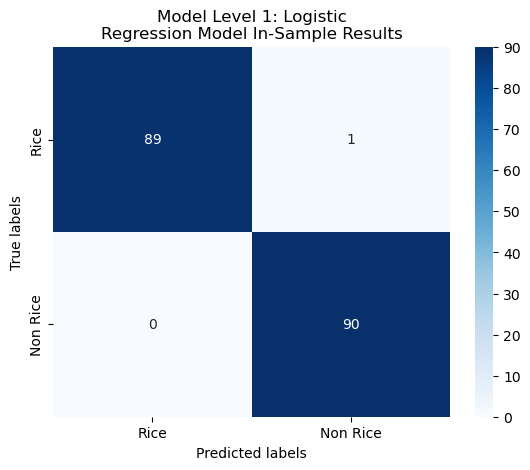

In [95]:
def plot_confusion_matrix(true_value,predicted_value,title,labels):
    '''
    Plots a confusion matrix.
    Attributes:
    true_value - The ground truth value for comparision.
    predicted_value - The values predicted by the model.
    title - Title of the plot.
    labels - The x and y labels of the plot.
    '''
    cm = confusion_matrix(true_value,predicted_value)
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, fmt='g', ax=ax, cmap='Blues');
    ax.set_xlabel('Predicted labels');
    ax.set_ylabel('True labels'); 
    ax.set_title(title); 
    ax.xaxis.set_ticklabels(labels); 
    ax.yaxis.set_ticklabels(labels);
    
plot_confusion_matrix(y_test,insample_predictions,"Model Level 1: Logistic\nRegression Model In-Sample Results",['Rice', 'Non Rice'])

# Test Data

In [98]:
#Reading the coordinates for the submission
test_file = pd.read_csv('challenge_1_submission_template_correct_columns_fixed.csv')
test_file.head()

,id,target
0,"(10.18019073690894, 105.32022315786804)",NaN
1,"(10.561107033461816, 105.12772097986661)",NaN
2,"(10.623790611954897, 105.13771401411867)",NaN
3,"(10.583364246115156, 105.23946127195805)",NaN
4,"(10.20744446668854, 105.26844107128906)",NaN


In [101]:
test_vh_vv_sleep = []
test_vh_vv = []
test_vh_vv_inactive = []
test_vh_vv_sleep_2 = []
test_vh_vv_2 = []
test_vh_vv_inactive_2 = []

In [100]:
test_vh_vv_sleep = pd.read_csv("crop_data_test_1.csv")
test_vh_vv_sleep = test_vh_vv_sleep.iloc[: , 1:]
test_vh_vv_sleep = test_vh_vv_sleep.values.tolist()
test_vh_vv_sleep = list(test_vh_vv_sleep)

# vh_vv_sleep

test_vh_vv = pd.read_csv("crop_data_test_2.csv")
test_vh_vv = test_vh_vv.iloc[: , 1:]
test_vh_vv = test_vh_vv.values.tolist()
test_vh_vv = list(test_vh_vv)

# # vh_vv

test_vh_vv_inactive = pd.read_csv("crop_data_test_3.csv")
test_vh_vv_inactive = test_vh_vv_inactive.iloc[: , 1:]
test_vh_vv_inactive = test_vh_vv_inactive.values.tolist()
test_vh_vv_inactive = list(test_vh_vv_inactive)

# # vh_vv_inactive

test_vh_vv_sleep_2 = pd.read_csv("crop_data_test_4.csv")
test_vh_vv_sleep_2 = test_vh_vv_sleep_2.iloc[: , 1:]
test_vh_vv_sleep_2 = test_vh_vv_sleep_2.values.tolist()
test_vh_vv_sleep_2 = list(test_vh_vv_sleep_2)

# # # vh_vv_sleep_2

test_vh_vv_2 = pd.read_csv("crop_data_test_5.csv")
test_vh_vv_2 = test_vh_vv_2.iloc[: , 1:]
test_vh_vv_2 = test_vh_vv_2.values.tolist()
test_vh_vv_2 = list(test_vh_vv_2)

# # # vh_vv_sleep

test_vh_vv_inactive_2 = pd.read_csv("crop_data_test_6.csv")
test_vh_vv_inactive_2 = test_vh_vv_inactive_2.iloc[: , 1:]
test_vh_vv_inactive_2 = test_vh_vv_inactive_2.values.tolist()
test_vh_vv_inactive_2 = list(test_vh_vv_inactive_2)

# # vh_vv_sleep

In [6]:
# test_vh_vv

In [ ]:
time_slice_sleep = "2021-11-01/2021-12-31"
time_slice = "2022-01-01/2022-02-28"
time_slice_inactive = "2022-03-01/2022-04-30"

time_slice_sleep_2 = "2022-04-01/2022-05-31"
time_slice_2 = "2022-05-01/2022-06-30"
time_slice_inactive_2 = "2022-07-01/2022-08-31"

i = 0
for coordinates in tqdm(test_file['id']):
    #print(get_sentinel_data(coordinates,time_slice))
    i = i + 1
    if i> len(test_vh_vv_sleep):
        test_vh_vv_sleep.append(get_sentinel_data(coordinates,time_slice_sleep)),
        sleep(0.5),
        test_vh_vv__sleep_data = pd.DataFrame(test_vh_vv_sleep,columns =['vh_s','vv_s'])
        test_vh_vv__sleep_data.to_csv('crop_data_test_1.csv'),

i = 0
for coordinates in tqdm(test_file['id']):
    #print(get_sentinel_data(coordinates,time_slice))
    i = i + 1
    if i> len(test_vh_vv):
        test_vh_vv.append(get_sentinel_data(coordinates,time_slice)),
        sleep(0.5),
        test_vh_vv_data = pd.DataFrame(test_vh_vv,columns =['vh','vv'])
        test_vh_vv_data.to_csv('crop_data_test_2.csv'),

i = 0
for coordinates in tqdm(test_file['id']):
    #print(get_sentinel_data(coordinates,time_slice))
    i = i + 1
    if i> len(test_vh_vv_inactive):
        test_vh_vv_inactive.append(get_sentinel_data(coordinates,time_slice_inactive)),
        sleep(0.5),
        test_vh_vv_inactive_data = pd.DataFrame(test_vh_vv_inactive,columns =['vh_i','vv_i'])
        test_vh_vv_inactive_data.to_csv('crop_data_test_3.csv'),

i = 0
for coordinates in tqdm(test_file['id']):
    #print(get_sentinel_data(coordinates,time_slice))
    i = i + 1
    if i> len(test_vh_vv_sleep_2):
        test_vh_vv_sleep_2.append(get_sentinel_data(coordinates,time_slice_sleep_2)),
        sleep(0.5),
        test_vh_vv_sleep_2_data = pd.DataFrame(test_vh_vv_sleep_2,columns =['vh2_s','vv2_s'])
        test_vh_vv_sleep_2_data.to_csv('crop_data_test_4.csv'),

i = 0
for coordinates in tqdm(test_file['id']):
    #print(get_sentinel_data(coordinates,time_slice))
    i = i + 1
    if i> len(test_vh_vv_2):
        test_vh_vv_2.append(get_sentinel_data(coordinates,time_slice_2)),
        sleep(0.5),
        test_vh_vv_2_data = pd.DataFrame(test_vh_vv_2,columns =['vh2','vv2'])
        test_vh_vv_2_data.to_csv('crop_data_test_5.csv'),
        
i = 0
for coordinates in tqdm(test_file['id']):
    #print(get_sentinel_data(coordinates,time_slice))
    i = i + 1
    if i> len(test_vh_vv_inactive_2):
        test_vh_vv_inactive_2.append(get_sentinel_data(coordinates,time_slice_inactive_2)),
        sleep(0.5),
        test_vh_vv_inactive_2_data = pd.DataFrame(test_vh_vv_inactive_2,columns =['vh2_i','vv2_i'])
        test_vh_vv_inactive_2_data.to_csv('crop_data_test_6.csv'),

#     if i> len(vh_vv):
#         vh_vv.append(get_sentinel_data(coordinates,time_slice)),
#         sleep(0.5),
#     if i> len(vh_vv_inactive):
#         vh_vv_inactive.append(get_sentinel_data(coordinates,time_slice_inactive)),
#         sleep(0.5),
#     if i> len(vh_vv_sleep_2):
#         vh_vv_sleep_2.append(get_sentinel_data(coordinates,time_slice_sleep_2)),
#         sleep(0.5),
#     if i> len(vh_vv_2):
#         vh_vv_2.append(get_sentinel_data(coordinates,time_slice_2)),
#         sleep(0.5),
#     if i> len(vh_vv_inactive_2):
#         vh_vv_inactive_2.append(get_sentinel_data(coordinates,time_slice_inactive_2))
#         sleep(0.5)

    


 10%|███████▌                                                                       | 24/250 [22:59<3:17:20, 52.39s/it]

In [33]:
test_vh_vv_data = pd.DataFrame(test_vh_vv,columns =['vh','vv'])
test_vh_vv_data_2 = pd.DataFrame(test_vh_vv_inactive,columns =['vh_i','vv_i'])
test_vh_vv_data_3 = pd.DataFrame(test_vh_vv_2,columns =['vh_2','vv_2'])
test_vh_vv_data_4 = pd.DataFrame(test_vh_vv_inactive_2,columns =['vh2_i','vv2_i'])
test_vh_vv_data_5 = pd.DataFrame(test_vh_vv_sleep,columns =['vh_s','vv_s'])
test_vh_vv_data_6 = pd.DataFrame(test_vh_vv_sleep_2,columns =['vh2_s','vv2_s'])

In [35]:
test_crop_data = combine_two_datasets(test_file,test_vh_vv_data_5)
test_crop_data = combine_two_datasets(test_crop_data,test_vh_vv_data)
test_crop_data = combine_two_datasets(test_crop_data,test_vh_vv_data_2)
test_crop_data = combine_two_datasets(test_crop_data,test_vh_vv_data_6)
test_crop_data = combine_two_datasets(test_crop_data,test_vh_vv_data_3)
test_crop_data = combine_two_datasets(test_crop_data,test_vh_vv_data_4)

test_crop_data.to_csv('crop_data_vv_vh_periodized_test_new.csv')

In [41]:
test_crop_data = pd.read_csv('crop_data_vv_vh_periodized_test_new.csv')

In [36]:
test_crop_data = test_crop_data[['vh_s','vv_s','vh','vv','vh_i','vv_i','vh2_s','vv2_s','vh_2','vv_2','vh2_i','vv2_i']]

rvi_data = []
rvi_data_2 = []
rvi_data_3 = []
rvi_data_4 = []
rvi_data_5 = []
rvi_data_6 = []

for row in test_crop_data.itertuples():
    vh_s = row[1]
    vv_s = row[2]
    vh_1 = row[3]
    vv_1 = row[4]
    vh_1i = row[5]
    vv_1i = row[6]
    vh_2s = row[7]
    vv_2s = row[8]
    vh_2 = row[9]
    vv_2 = row[10]
    vh_2i = row[11]
    vv_2i = row[12]
    
    rvi = math.sqrt(1- vv_s / (vv_s+vh_s)) * 4 * (vh_s / (vv_s + vh_s))
    rvi_2 = math.sqrt(1- vv_1 / (vv_1+vh_1)) * 4 * (vh_1 / (vv_1 + vh_1))
    rvi_3 = math.sqrt(1- vv_1i / (vv_1i+vh_1i)) * 4 * (vh_1i / (vv_1i + vh_1i))
    rvi_4 = math.sqrt(1- vv_2s / (vv_2s+vh_2s)) * 4 * (vh_2s / (vv_2s + vh_2s))
    rvi_5 = math.sqrt(1- vv_2 / (vv_2+vh_2)) * 4 * (vh_2 / (vv_2 + vh_2))
    rvi_6 = math.sqrt(1- vv_2i / (vv_2i+vh_2i)) * 4 * (vh_2i / (vv_2i + vh_2i))
    
    rvi_data.append(rvi)
    rvi_data_2.append(rvi_2)
    rvi_data_3.append(rvi_3)
    rvi_data_4.append(rvi_4)
    rvi_data_5.append(rvi_5)
    rvi_data_6.append(rvi_6)

rvi_combined = pd.DataFrame(rvi_data,columns =['rvi'])
rvi_dataframe_2 = pd.DataFrame(rvi_data_2,columns =['rvi_2'])
rvi_dataframe_3 = pd.DataFrame(rvi_data_3,columns =['rvi_3'])
rvi_dataframe_4 = pd.DataFrame(rvi_data_4,columns =['rvi_4'])
rvi_dataframe_5 = pd.DataFrame(rvi_data_5,columns =['rvi_5'])
rvi_dataframe_6 = pd.DataFrame(rvi_data_6,columns =['rvi_6'])
rvi_combined = combine_two_datasets(rvi_combined,rvi_dataframe_2)
rvi_combined = combine_two_datasets(rvi_combined,rvi_dataframe_3)
rvi_combined = combine_two_datasets(rvi_combined,rvi_dataframe_4)
rvi_combined = combine_two_datasets(rvi_combined,rvi_dataframe_5)
rvi_combined = combine_two_datasets(rvi_combined,rvi_dataframe_6)

test_crop_data_rvi = combine_two_datasets(test_crop_data,rvi_combined)

In [37]:
test_crop_data_rvi

,vh_s,vv_s,vh,vv,vh_i,vv_i,vh2_s,vv2_s,vh_2,vv_2,vh2_i,vv2_i,rvi,rvi_2,rvi_3,rvi_4,rvi_5,rvi_6
0,0.004163,0.012135,0.022239,0.054756,0.024604,0.099665,0.016296,0.160690,0.033696,0.138849,0.029297,0.180081,0.516416,0.620924,0.352398,0.111757,0.345208,0.209360
1,0.004557,0.024406,0.026327,0.093042,0.024265,0.093601,0.026764,0.185933,0.035097,0.179409,0.024702,0.078258,0.249640,0.414310,0.373628,0.178547,0.264735,0.470065
2,0.006731,0.096155,0.016527,0.104547,0.024912,0.123112,0.024842,0.158817,0.028339,0.178877,0.037400,0.148310,0.066935,0.201728,0.276168,0.198990,0.202307,0.361506
3,0.003841,0.013920,0.004478,0.013609,0.004488,0.017065,0.009685,0.044475,0.008927,0.042428,0.004243,0.013818,0.402293,0.492775,0.380123,0.302474,0.289879,0.455485
4,0.011934,0.178370,0.022661,0.058490,0.026265,0.140115,0.021447,0.167232,0.021513,0.068618,0.034411,0.211601,0.062813,0.590245,0.250889,0.153291,0.466436,0.209252
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
245,0.005383,0.019359,0.005486,0.023010,0.005486,0.013639,0.005084,0.015090,0.010836,0.014783,0.029965,0.233243,0.405943,0.337870,0.614525,0.506085,1.100333,0.153649
246,0.003344,0.011103,0.004047,0.017272,0.004615,0.018184,0.004381,0.013641,0.012581,0.059045,0.003601,0.015837,0.445403,0.330808,0.364303,0.479372,0.294462,0.318970
247,0.004066,0.011977,0.004592,0.011034,0.005499,0.017423,0.009554,0.050397,0.009391,0.047797,0.005663,0.018068,0.510377,0.637197,0.469974,0.254487,0.266175,0.466263
248,0.005234,0.114098,0.024837,0.129831,0.019682,0.095603,0.026328,0.175441,0.026729,0.174873,0.038315,0.169018,0.036747,0.257396,0.282169,0.188538,0.193099,0.317769


In [50]:
# crop_data
test_data = sc.transform(test_crop_data_rvi)

In [96]:
# Predictions

test_predictions = rf_model.predict(test_data)

test_predictions

test_predictions = pd.DataFrame(test_predictions,columns =['target'])

test_predictions['target'].value_counts()['Rice']

117

In [75]:
# Submission in the template required (Coordinates, Prediction)

submission_template = pd.read_csv('challenge_1_submission_template_correct_columns_fixed.csv')
submission_template = submission_template['id']
submission_template = combine_two_datasets(submission_template,test_predictions)
submission_template.to_csv('predictions.csv')